<a href="https://colab.research.google.com/github/mc-robinson/RMD_colab_notebooks/blob/master/M1_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M1 (Note these are switched with CCR5) #

As used in [Ligand biological activity predicted by cleaning positive and negative chemical correlations](https://www.pnas.org/content/116/9/3373).

Now done with nested CV and more extensive hyperparameter optimization

In [0]:
!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y --prefix /usr/local -c rdkit rdkit

import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')

In [0]:
import PIL #needed for IPythonConsole

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole #needed to show molecules

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
actives_url = 'https://www.pnas.org/highwire/filestream/848445/field_highwire_adjunct_files/4/pnas.1810847116.sd04.xlsx'
actives_df = pd.read_excel(actives_url)

decoys_url = 'https://www.pnas.org/highwire/filestream/848445/field_highwire_adjunct_files/6/pnas.1810847116.sd06.xlsx'
decoys_df = pd.read_excel(decoys_url)

In [5]:
actives_df.head()

,"Active compounds in the CCR5 training set, represented as 1024 bit Morgan fingerprint of radius 3",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,...,Unnamed: 984,Unnamed: 985,Unnamed: 986,Unnamed: 987,Unnamed: 988,Unnamed: 989,Unnamed: 990,Unnamed: 991,Unnamed: 992,Unnamed: 993,Unnamed: 994,Unnamed: 995,Unnamed: 996,Unnamed: 997,Unnamed: 998,Unnamed: 999,Unnamed: 1000,Unnamed: 1001,Unnamed: 1002,Unnamed: 1003,Unnamed: 1004,Unnamed: 1005,Unnamed: 1006,Unnamed: 1007,Unnamed: 1008,Unnamed: 1009,Unnamed: 1010,Unnamed: 1011,Unnamed: 1012,Unnamed: 1013,Unnamed: 1014,Unnamed: 1015,Unnamed: 1016,Unnamed: 1017,Unnamed: 1018,Unnamed: 1019,Unnamed: 1020,Unnamed: 1021,Unnamed: 1022,Unnamed: 1023
0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [6]:
decoys_df.head()

,"Inactive compounds in the CCR5 training set, represented as 1024 bit Morgan fingerprint of radius 3",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,...,Unnamed: 984,Unnamed: 985,Unnamed: 986,Unnamed: 987,Unnamed: 988,Unnamed: 989,Unnamed: 990,Unnamed: 991,Unnamed: 992,Unnamed: 993,Unnamed: 994,Unnamed: 995,Unnamed: 996,Unnamed: 997,Unnamed: 998,Unnamed: 999,Unnamed: 1000,Unnamed: 1001,Unnamed: 1002,Unnamed: 1003,Unnamed: 1004,Unnamed: 1005,Unnamed: 1006,Unnamed: 1007,Unnamed: 1008,Unnamed: 1009,Unnamed: 1010,Unnamed: 1011,Unnamed: 1012,Unnamed: 1013,Unnamed: 1014,Unnamed: 1015,Unnamed: 1016,Unnamed: 1017,Unnamed: 1018,Unnamed: 1019,Unnamed: 1020,Unnamed: 1021,Unnamed: 1022,Unnamed: 1023
0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [0]:
decoys_df['class'] = 0
actives_df['class'] = 1

X = np.concatenate((np.array(decoys_df.iloc[:,:-1]),np.array(actives_df.iloc[:,:-1])),axis=0)
y = np.concatenate((np.array(decoys_df.iloc[:,-1]), np.array(actives_df.iloc[:,-1])))

In [8]:
print(f'fingerprint length: {X.shape[1]}')
print(f'number of actives: {y[y==1].shape[0]}')
print(f'number of decoys: {y[y==0].shape[0]}')

fingerprint length: 1024
number of actives: 640
number of decoys: 490


In [9]:
!git clone https://github.com/mc-robinson/RMD_colab_notebooks.git

Cloning into 'RMD_colab_notebooks'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 27 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (27/27), done.


In [0]:
!cp RMD_colab_notebooks/chem_rmd.py .

In [0]:
def classical_AUC_CI(AUC, n_actives, n_inactives):
    import scipy.stats
    
    var_active = ((AUC**2)*(1-AUC)/(1+AUC))/n_actives
    var_inactive = (AUC*((1-AUC)**2)/(2-AUC))/n_inactives
    
    df_eff = (
        (((var_active/n_actives)+(var_inactive/n_inactives))**2) / 
        (
            (((var_active/n_actives)**2)/(n_actives-1)) +
            (((var_inactive/n_inactives)**2)/(n_inactives-1))
        )
    )
    
    std_error = np.sqrt(var_active+var_inactive)
    
    logit_auc = np.log(AUC/(1-AUC))
    logit_std_error = std_error * (1/(AUC*(1-AUC)))
    
    t_95 = scipy.stats.t.ppf(0.975,df_eff)
    logit_lower_limit = logit_auc - t_95*logit_std_error
    logit_upper_limit = logit_auc + t_95*logit_std_error
    
    lower_limit = 1/(1+np.exp(-1*logit_lower_limit))
    upper_limit = 1/(1+np.exp(-1*logit_upper_limit))
    
    return lower_limit, upper_limit


In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

def plot_roc_curves(y_test, y_scores, title='ROC curves'):

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize=(6,4))
    for i in range(len(y_scores)):
        # Compute ROC curve and area the curve
        scores = y_scores[i]
        classes = y_test[i]
        fpr, tpr, thresholds = roc_curve(classes, scores)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='Run %d (AUC = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    #print('mean auc', np.mean(aucs))
    if len(y_scores) > 1:
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')
    else:    
        n_actives = sum(y_test[y_test==1])
        n_inactives = sum(y_test[y_test==0])
        AUC_CI_lower, AUC_CI_upper = classical_AUC_CI(aucs[0],
                                                      n_actives,
                                                      n_inactives)
        plt.text(0.33,0.2,f'AUC CI from formula {round(AUC_CI_lower,3),round(AUC_CI_upper,3)}')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='upper center', bbox_to_anchor=(1.4, 1.0), shadow=True, ncol=1)
    plt.show()

In [0]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curves(y_test, y_scores, title='PR Curves'):

    precisions = []
    aucs = []
    mean_recall = np.linspace(0, 1, 100)

    plt.figure(figsize=(6,4))

    for i in range(len(y_scores)):
        scores = y_scores[i]
        classes = y_test[i]
        precision, recall, thresholds = precision_recall_curve(classes, scores)
        avg_precision = average_precision_score(classes, scores)
        aucs.append(avg_precision)
        #aucs.append(auc(recall, precision))
        plt.step(recall, precision, color='b', alpha=0.2,
             where='post',label='Run %d (AUC = %0.2f)' % (i, avg_precision))

        i += 1

    if len(y_scores)>1:
        print('MEAN PR-AUC:', np.mean(aucs))
        print('STD PR-AUC:', np.std(aucs))
        std_auc = np.std(aucs)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1), shadow=True, ncol=1)
    plt.show()

### Perform Nested Cross Validation On Each Algorithm ###

To be extra safe that the dataframe is not ordered in a way that could bias the data, first shuffle the data. Note that every random state in this dataset will be set to 42, to maintain reproducibility. 

In [0]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

# RMD # 

In [0]:
from chem_rmd import RMD
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

def rmd_GridSearchCV(X, y, n_folds=5):
    
    scoring_list = ['theoretical', 'basic', 'weighted',
                    'dist_to_positive', 'dist_to_negative']
    scoring_dict = dict.fromkeys(scoring_list, 0)

    for scoring in scoring_list:
        sss = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=False)
        for train_index, test_index in sss.split(X, y): 
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            rmd = RMD()
            rmd.fit(X_train, y_train)
            y_pred = rmd.predict_scores(X_test,scoring=scoring )
            metric = roc_auc_score(y_test, y_pred)
            scoring_dict[scoring] = scoring_dict[scoring] + metric/n_folds
    
    #scoring_dict = {k,(v/n_folds) for k,v in scoring_dict.items()}
    best_scoring = [k for k,v in scoring_dict.items() if v==max(scoring_dict.values())][0]
    return best_scoring, scoring_dict

In [0]:
# nested CV

def nested_RMD_CV(X, y, n_outer_folds=5, n_inner_folds=4, verbose=True):
    
    y_test_list = []
    y_pred_list = []
    # Perform Outer CV Loop
    sss = StratifiedKFold(n_splits=n_outer_folds, random_state=42,
                          shuffle=False)
    for train_index, test_index in sss.split(X, y): 
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # inner loop
        best_scoring, _ = rmd_GridSearchCV(X_train, y_train,
                                           n_folds=n_inner_folds)
        
        # retrain best classifier on all of X_train, y_train
        rmd = RMD()
        rmd.fit(X_train, y_train)
        
        # test on outer test fold
        rmd_scores = rmd.predict_scores(X_test, scoring=best_scoring)
        metric = roc_auc_score(y_test, rmd_scores)
        
        y_test_list.append(y_test)
        y_pred_list.append(rmd_scores)
        
        if verbose:
            print('Best parameter value: ', best_scoring)
            print('ROC-AUC: ', metric)
        
    return y_test_list, y_pred_list

    

In [17]:
%%time
y_test_list, rmd_pred_list = nested_RMD_CV(X, y)

Best parameter value:  weighted
ROC-AUC:  0.9346301020408162
Best parameter value:  weighted
ROC-AUC:  0.9510921556122448
Best parameter value:  weighted
ROC-AUC:  0.9649234693877551
Best parameter value:  basic
ROC-AUC:  0.9292091836734694
Best parameter value:  weighted
ROC-AUC:  0.9495376275510204
CPU times: user 7min 29s, sys: 2min 24s, total: 9min 54s
Wall time: 4min 59s


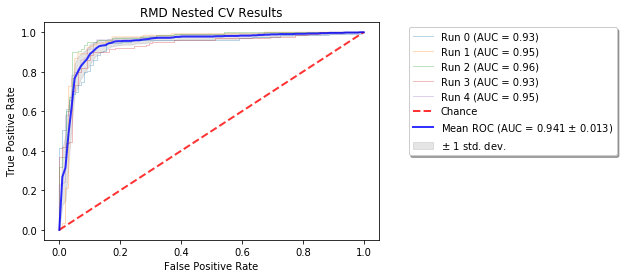

In [18]:
plot_roc_curves(y_test_list, rmd_pred_list, 'RMD Nested CV Results')

MEAN PR-AUC: 0.9492982655794485
STD PR-AUC: 0.0151611614183638


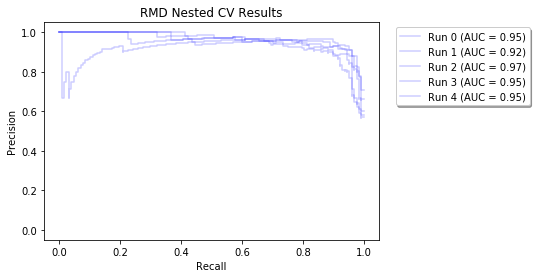

In [19]:
plot_pr_curves(y_test_list, rmd_pred_list, 'RMD Nested CV Results')

In [0]:
def nested_cv(X, y, clf, param_grid, n_jobs=-1, 
              n_outer_folds=5, n_inner_folds=4, verbose=0):
    
    from sklearn.model_selection import GridSearchCV
    
    y_test_list = []
    y_pred_list = []
    # Perform Outer CV Loop
    sss = StratifiedKFold(n_splits=n_outer_folds, random_state=42,
                          shuffle=False)
    for train_index, test_index in sss.split(X, y): 
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # inner loop
        # need to create own cv generator so set random state
        inner_cv =  StratifiedKFold(n_splits=n_inner_folds, random_state=42,
                                    shuffle=False)
        grid = GridSearchCV(clf,
                            cv=inner_cv,
                            n_jobs=n_jobs,
                            verbose=verbose,
                            param_grid=param_grid,
                            scoring='roc_auc')
        grid.fit(X_train, y_train)
        
        # retrain best classifier on all of X_train, y_train
        best_clf = grid.best_estimator_
        best_clf.fit(X_train, y_train)
        
        # test on outer test fold
        try:
            best_clf_scores = best_clf.decision_function(X_test)
        except(NotImplementedError, AttributeError):
            best_clf_scores = best_clf.predict_proba(X_test)[:,1]
            
        metric = roc_auc_score(y_test, best_clf_scores)
        
        y_test_list.append(y_test)
        y_pred_list.append(best_clf_scores)
        
        if verbose == 0:
            print('Best parameter values: ', grid.best_params_)
            print('Outer fold ROC-AUC: ', metric)
        
    return y_test_list, y_pred_list

# NB

In [21]:
%%time
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB()
alpha_range = np.arange(0.0, 2, 0.1)
nb_param_grid = dict(alpha=alpha_range)

y_test_list, nb_pred_list = nested_cv(X, y, nb, nb_param_grid, n_jobs=-1, 
                                        n_outer_folds=5, n_inner_folds=4, verbose=0)

Best parameter values:  {'alpha': 1.2000000000000002}
Outer fold ROC-AUC:  0.909359056122449
Best parameter values:  {'alpha': 0.2}
Outer fold ROC-AUC:  0.9494977678571429
Best parameter values:  {'alpha': 0.2}
Outer fold ROC-AUC:  0.9188058035714286
Best parameter values:  {'alpha': 0.30000000000000004}
Outer fold ROC-AUC:  0.8876355229591837
Best parameter values:  {'alpha': 0.9}
Outer fold ROC-AUC:  0.9281728316326531
CPU times: user 800 ms, sys: 311 ms, total: 1.11 s
Wall time: 19.7 s


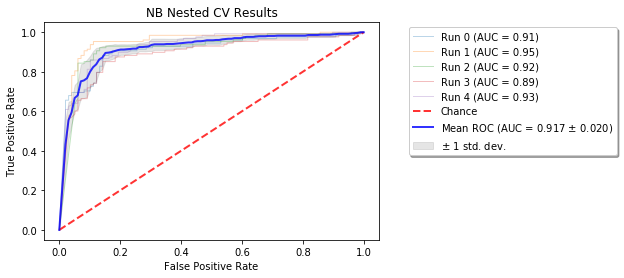

In [22]:
plot_roc_curves(y_test_list, nb_pred_list, 'NB Nested CV Results')

MEAN PR-AUC: 0.9289407121585345
STD PR-AUC: 0.01272257430781725


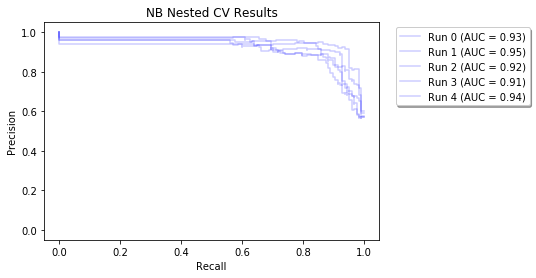

In [23]:
plot_pr_curves(y_test_list, nb_pred_list, 'NB Nested CV Results')

# KNN

In [24]:
%%time
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
neighbors_range = np.arange(2,8,1)
weights_range = ['uniform','distance']
knn_param_grid = dict(n_neighbors=neighbors_range, weights=weights_range)

y_test_list, knn_pred_list = nested_cv(X, y, knn, knn_param_grid, n_jobs=-1, 
                                        n_outer_folds=5, n_inner_folds=4, verbose=0)

Best parameter values:  {'n_neighbors': 5, 'weights': 'uniform'}
Outer fold ROC-AUC:  0.9291693239795917
Best parameter values:  {'n_neighbors': 5, 'weights': 'uniform'}
Outer fold ROC-AUC:  0.9561144770408163
Best parameter values:  {'n_neighbors': 5, 'weights': 'uniform'}
Outer fold ROC-AUC:  0.9744100765306123
Best parameter values:  {'n_neighbors': 6, 'weights': 'uniform'}
Outer fold ROC-AUC:  0.9374202806122449
Best parameter values:  {'n_neighbors': 7, 'weights': 'uniform'}
Outer fold ROC-AUC:  0.9525271045918366
CPU times: user 3.09 s, sys: 71.1 ms, total: 3.16 s
Wall time: 3min 21s


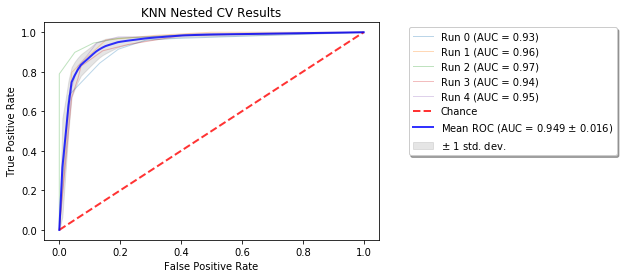

In [25]:
plot_roc_curves(y_test_list, knn_pred_list, 'KNN Nested CV Results')

MEAN PR-AUC: 0.9444130206638747
STD PR-AUC: 0.01844299977750162


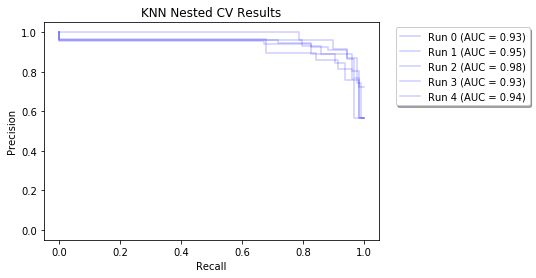

In [26]:
plot_pr_curves(y_test_list, knn_pred_list, 'KNN Nested CV Results')

# RF

In [27]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
n_estimators_range = [1000]
max_features_range = int(np.sqrt(X.shape[1])) * np.array([1,2,3])
rf_param_grid = dict(n_estimators=n_estimators_range,
                  max_features=max_features_range)

y_test_list, rf_pred_list = nested_cv(X, y, rf, rf_param_grid, n_jobs=-1, 
                                        n_outer_folds=5, n_inner_folds=4, verbose=0)

Best parameter values:  {'max_features': 32, 'n_estimators': 1000}
Outer fold ROC-AUC:  0.9589445153061225
Best parameter values:  {'max_features': 32, 'n_estimators': 1000}
Outer fold ROC-AUC:  0.9701052295918368
Best parameter values:  {'max_features': 32, 'n_estimators': 1000}
Outer fold ROC-AUC:  0.9733338647959184
Best parameter values:  {'max_features': 32, 'n_estimators': 1000}
Outer fold ROC-AUC:  0.9415656887755103
Best parameter values:  {'max_features': 32, 'n_estimators': 1000}
Outer fold ROC-AUC:  0.9517697704081634
CPU times: user 28.6 s, sys: 112 ms, total: 28.7 s
Wall time: 2min 54s


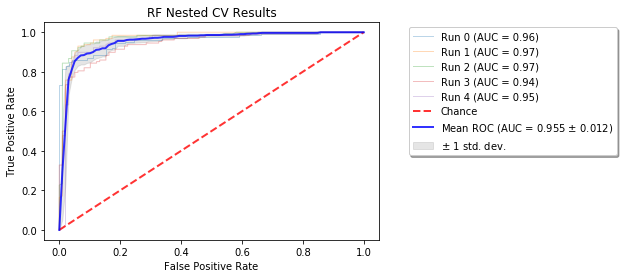

In [28]:
plot_roc_curves(y_test_list, rf_pred_list, 'RF Nested CV Results')

MEAN PR-AUC: 0.9600354102779383
STD PR-AUC: 0.019796670838412522


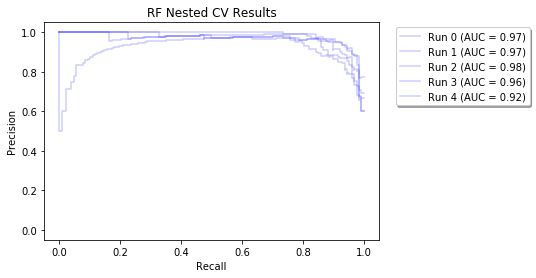

In [29]:
plot_pr_curves(y_test_list, rf_pred_list, 'RF Nested CV Results')

# SVM

In [30]:
%%time

from sklearn.svm import SVC

svm = SVC()
C_range = 10. ** np.arange(-1, 3, 1)
gamma_range = 10. ** np.arange(-3, 2, 2)
svm_param_grid = dict(gamma=gamma_range, C=C_range)

y_test_list, svm_pred_list = nested_cv(X, y, svm, svm_param_grid, n_jobs=-1, 
                                        n_outer_folds=5, n_inner_folds=4, verbose=0)

Best parameter values:  {'C': 100.0, 'gamma': 0.001}
Outer fold ROC-AUC:  0.9363042091836735
Best parameter values:  {'C': 10.0, 'gamma': 0.001}
Outer fold ROC-AUC:  0.9608976403061225
Best parameter values:  {'C': 10.0, 'gamma': 0.001}
Outer fold ROC-AUC:  0.9528858418367347
Best parameter values:  {'C': 100.0, 'gamma': 0.001}
Outer fold ROC-AUC:  0.9342315051020409
Best parameter values:  {'C': 10.0, 'gamma': 0.001}
Outer fold ROC-AUC:  0.9530452806122449
CPU times: user 6.85 s, sys: 73.7 ms, total: 6.93 s
Wall time: 3min 10s


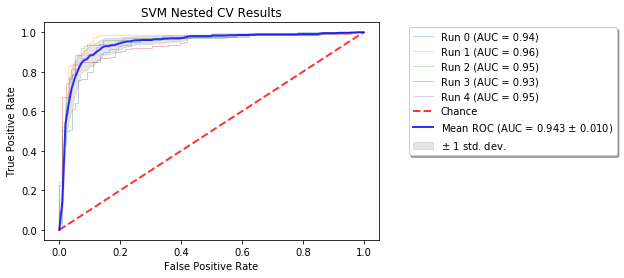

In [31]:
plot_roc_curves(y_test_list, svm_pred_list, 'SVM Nested CV Results')

MEAN PR-AUC: 0.9535630107330182
STD PR-AUC: 0.00828240531184029


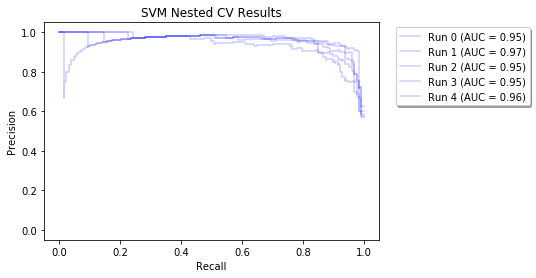

In [32]:
plot_pr_curves(y_test_list, svm_pred_list, 'SVM Nested CV Results')

# DNN

Note that this will not involve nested-CV, because no hyperparameter optimization will be done for ease of implementation. Sensible default values will be chosen and used across all folds

In [0]:
import torch
import fastai
from fastai.tabular import *

In [0]:
import torch.nn as nn
import torch.nn.functional as F

def bn_drop_lin(n_in:int, n_out:int, bn:bool=True,
                p:float=0., actn:Optional[nn.Module]=None):
    "`n_in`->bn->dropout->linear(`n_in`,`n_out`)->`actn`"
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

class Simple_DNN(nn.Module):
    def __init__(self, n_in, n_hidden=[512, 512, 512], n_out=2, dropout=0.5):
        super(Simple_DNN, self).__init__()
    
        layers = []
        layers += bn_drop_lin(n_in, n_hidden[0],
                              bn=False, p=0.0,
                              actn=nn.ReLU(inplace=True))
        for i in range(len(n_hidden)-1):
            layers += bn_drop_lin(n_hidden[i], n_hidden[i+1],
                                bn=False, p=dropout,
                                actn=nn.ReLU(inplace=True))
        layers += bn_drop_lin(n_hidden[-1], n_out,
                                bn=False, p=dropout,
                                actn=None)
    
        self.layers = nn.Sequential(*layers)
    
    def forward(self, xb):
        xb = self.layers(xb)
        return xb

In [0]:
def dnn_cv(X, y, n_outer_folds=5, verbose=True):
    
    y_test_list = []
    y_pred_list = []
    # Perform Outer CV Loop
    sss = StratifiedKFold(n_splits=n_outer_folds, random_state=42,
                          shuffle=False)
    for train_index, test_index in sss.split(X, y): 
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # convert to pytorch tensors
        X_train, y_train, X_test, y_test = \
        map(
          partial(torch.tensor, dtype=torch.float),
          (X_train, y_train, X_test, y_test)
        )
        y_train = y_train.long()
        y_test = y_test.long()

        # construct pytorch datasets
        train_ds = TensorDataset(X_train, y_train)
        test_ds = TensorDataset(X_test, y_test)

        # construct fastai databunch
        bs = 64
        data = DataBunch.create(train_ds, test_ds, bs=bs)
        
        # define and train dnn
        learn = Learner(data,
                Simple_DNN(n_in=X_train.shape[1],
                           n_hidden=[64,64],
                           n_out=2,
                           dropout=0.5),
                loss_func=CrossEntropyFlat())
        
        learn.fit_one_cycle(10, 1e-03)
        learn.fit_one_cycle(5, 1e-05)
        
        dnn_log_probs = get_preds(learn.model, data.valid_dl)[0]
        dnn_scores = np.exp(dnn_log_probs[:,1])
        
        metric = roc_auc_score(y_test, dnn_scores)
        
        y_test_list.append(y_test.numpy())
        y_pred_list.append(dnn_scores.numpy())
        
        if verbose:
            print('ROC-AUC: ', metric)
        
    return y_test_list, y_pred_list

In [36]:
%%time
y_test_list, dnn_pred_list = dnn_cv(X, y, n_outer_folds=5, verbose=True)

ROC-AUC:  0.9569515306122449
CPU times: user 6.67 s, sys: 4.19 s, total: 10.9 s
Wall time: 17.3 s


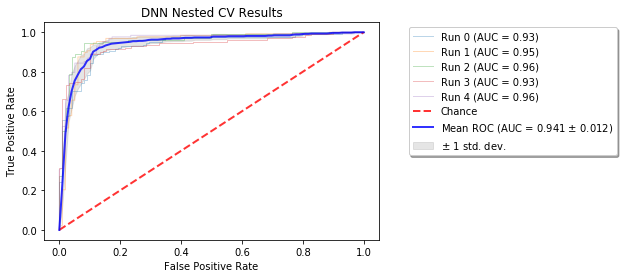

In [37]:
from sklearn.metrics import roc_curve, auc # b/c fastai was overwriting a metric
plot_roc_curves(y_test_list, dnn_pred_list, 'DNN Nested CV Results')

MEAN PR-AUC: 0.9541375954233342
STD PR-AUC: 0.011444387169786576


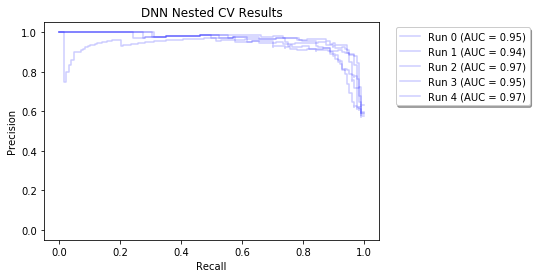

In [38]:
plot_pr_curves(y_test_list, dnn_pred_list, 'DNN Nested CV Results')

# How Similar Are the Methods? #

In [0]:
num_scores = len(rmd_pred_list[0].argsort().argsort())
test0_ranks_df = pd.DataFrame({
                                'rmd': num_scores - rmd_pred_list[0].argsort().argsort(),
                                'knn': num_scores - knn_pred_list[0].argsort().argsort(),
                                'nb': num_scores - nb_pred_list[0].argsort().argsort(),
                                'rf': num_scores - rf_pred_list[0].argsort().argsort(),
                                'svm': num_scores - svm_pred_list[0].argsort().argsort(),
                                'dnn': num_scores - dnn_pred_list[0].argsort().argsort(),
                            })

### Let's plot how the compounds rank each compound, and see how correlated the methods are. Compounds at low ranks are those judged to be most likely to be active by the classifier.

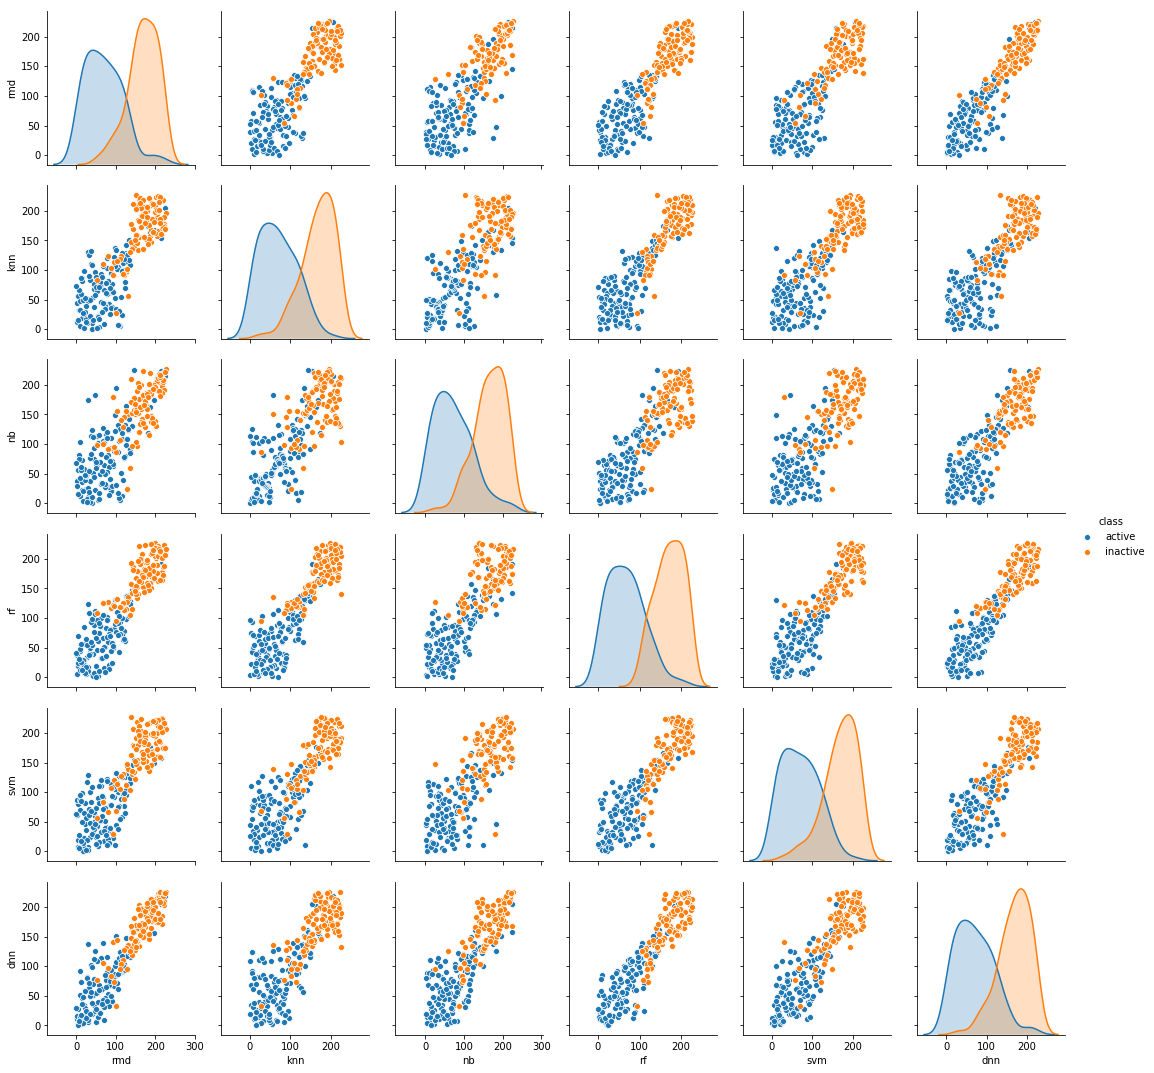

In [40]:
import seaborn as sns

test0_ranks_df['class'] = y_test_list[0]
test0_ranks_df['class'] = test0_ranks_df['class'].apply(lambda x: 'active' if x==1 else 'inactive')
sns.pairplot(test0_ranks_df, hue='class')

### Let's do it for one more test set:

In [0]:
num_scores = len(rmd_pred_list[0].argsort().argsort())
test5_ranks_df = pd.DataFrame({
                                'rmd': num_scores - rmd_pred_list[-1].argsort().argsort(),
                                'knn': num_scores - knn_pred_list[-1].argsort().argsort(),
                                'nb': num_scores - nb_pred_list[-1].argsort().argsort(),
                                'rf': num_scores - rf_pred_list[-1].argsort().argsort(),
                                'svm': num_scores - svm_pred_list[-1].argsort().argsort(),
                                'dnn': num_scores - dnn_pred_list[-1].argsort().argsort(),
                            })

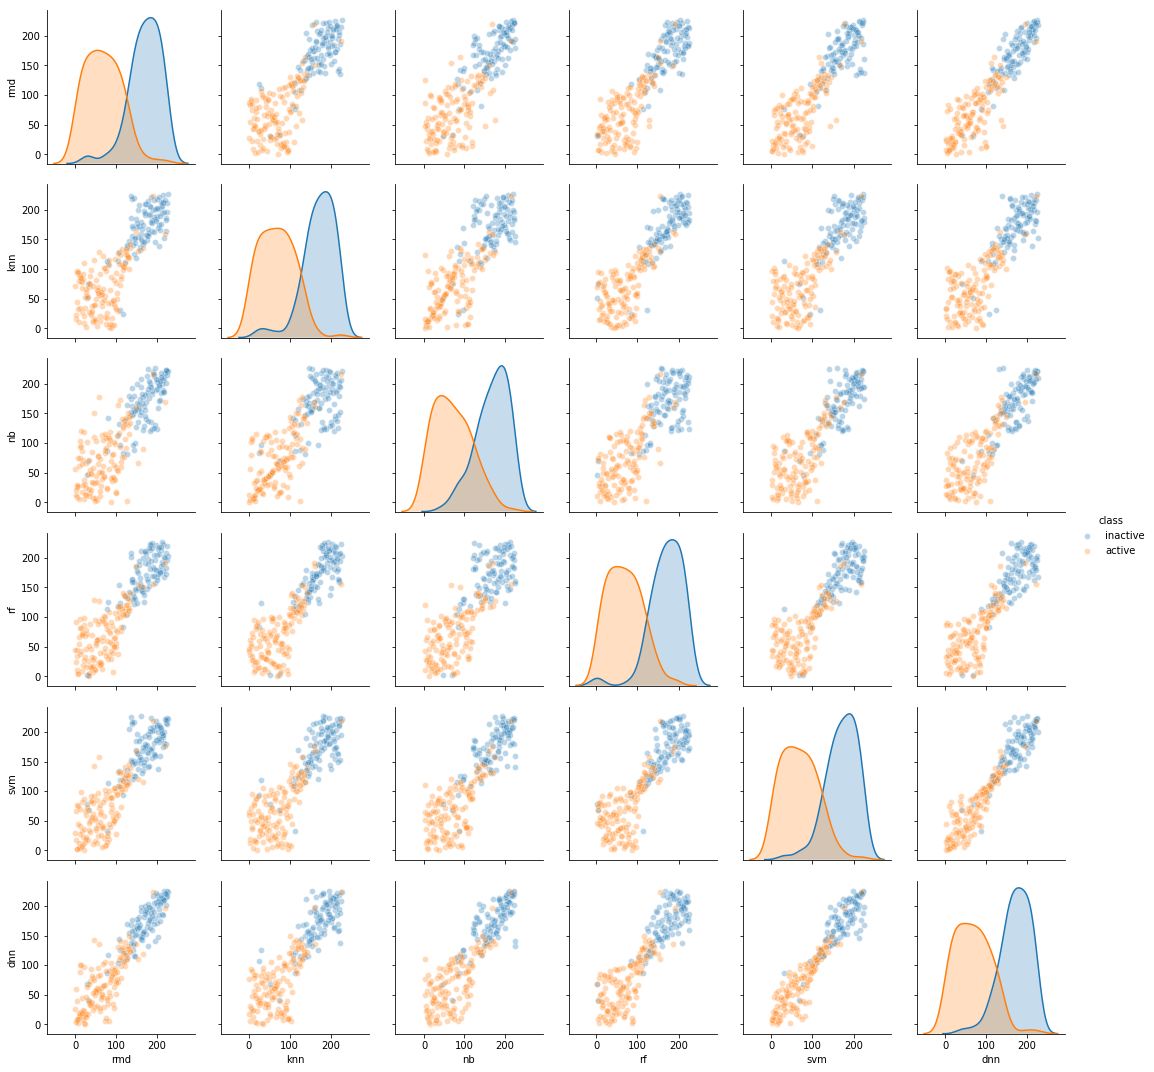

In [42]:
test5_ranks_df['class'] = y_test_list[-1]
test5_ranks_df['class'] = test5_ranks_df['class'].apply(lambda x: 'active' if x==1 else 'inactive')
sns.pairplot(test5_ranks_df, hue='class', plot_kws={'alpha':0.3} )

### Look how similar the NB and DNN predictions are in both cases. Furthermroe, the RF and SVM predictions are very similar

### The algorithms are still a bit uncorrelated at the top of the actives, let's see if we can help by using a voting classifier:

In [0]:
voting_aucs_list = []
for i in range(len(y_test_list)):
    vote_ranks_arr = np.vstack((rmd_pred_list[i].argsort().argsort(),
                             knn_pred_list[i].argsort().argsort(),
                             nb_pred_list[i].argsort().argsort(),
                             rf_pred_list[i].argsort().argsort(),
                             svm_pred_list[i].argsort().argsort(),
                             dnn_pred_list[i].argsort().argsort()))
    vote_pred = np.mean(vote_ranks_arr, axis=0)
    
    voting_aucs_list.append(roc_auc_score(y_test_list[i], vote_pred))

In [44]:
voting_aucs_list

[0.9520886479591838,
 0.963687818877551,
 0.9656409438775511,
 0.9415656887755103,
 0.9579878826530612]

In [45]:
np.mean(voting_aucs_list)

0.9561941964285714

In [46]:
np.std(voting_aucs_list)

0.008711618557245688

In [0]:
X_test_list = []
sss = StratifiedKFold(n_splits=5, random_state=42,
                          shuffle=False)
for train_index, test_index in sss.split(X, y): 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_test_list.append(X_test)

In [0]:
def tanimoto(v1, v2):
    """
    Calculates tanimoto similarity for two bit vectors
    """
    return(np.bitwise_and(v1, v2).sum() / np.bitwise_or(v1, v2).sum())

dists = []
fps = X_test_list[0]
activity = y_test_list[0]
active_fps = fps[activity==1]
nfps = active_fps.shape[0]

fp_sims_list = []
for i in range(nfps):
    sims = []
    for j in range(nfps):
        if i != j:
            sims.append(tanimoto(active_fps[i], active_fps[j]))
    fp_sims_list.append(np.mean(sims))

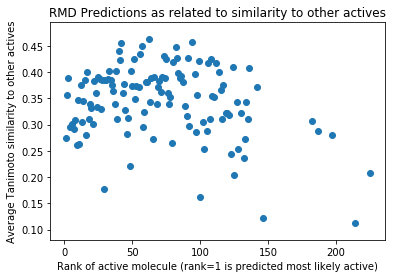

In [49]:
plt.scatter(num_scores - rmd_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('RMD Predictions as related to similarity to other actives');

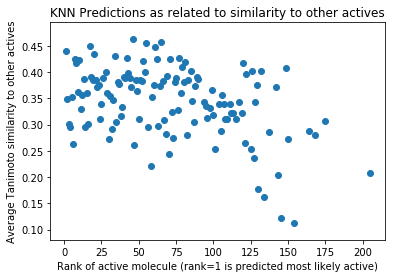

In [50]:
plt.scatter(num_scores - knn_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('KNN Predictions as related to similarity to other actives');

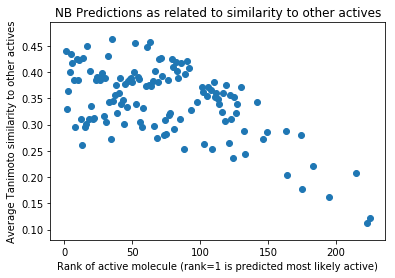

In [51]:
plt.scatter(num_scores - nb_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('NB Predictions as related to similarity to other actives');

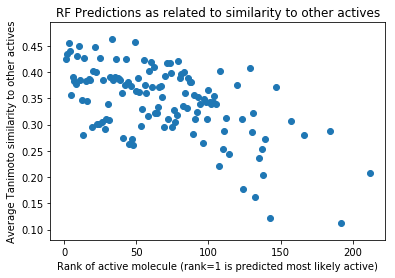

In [52]:
plt.scatter(num_scores - rf_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('RF Predictions as related to similarity to other actives');

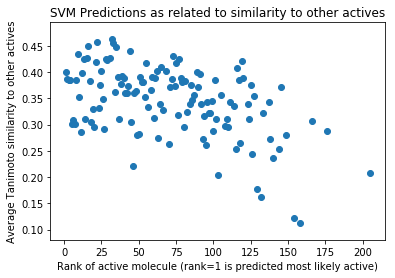

In [53]:
plt.scatter(num_scores - svm_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('SVM Predictions as related to similarity to other actives');

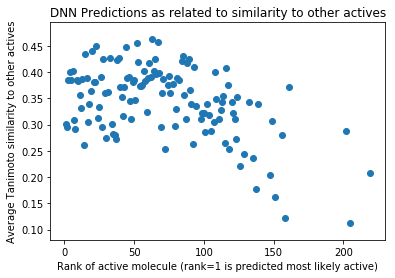

In [54]:
plt.scatter(num_scores - dnn_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('DNN Predictions as related to similarity to other actives');